# Bias-variance tradeoff 

In [1]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Train two classifiers on relatively large dataset 

We consider here a relatively simple prediction task with a relatively small feature set and an impossible prediction task with the same feature set for comparison.

In [2]:
sampler_0 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([0, 0])))
sampler_1 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([10, 10])))

Again use majority voting and logistic regression as classifiers to compare

In [3]:
train = sampler_0(100)
features = list(train.columns.values[:-1])
clf_1 = MajorityVoting(features)
clf_1.fit(train, train['y'])
clf_2 = LogisticRegression(solver = 'lbfgs')
clf_2.fit(train[features], train['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Simple test run to see that all functions are correctly defined

In [4]:
print('MV training error: {:.2f}%'.format(empirical_risk(clf_1, train[features], train['y'])))
print('LR training error: {:.2f}%'.format(empirical_risk(clf_2, train[features], train['y'])))

MV training error: 11.00%
LR training error: 37.00%


## II. Measuring training and test error on different dataset sizes

### Configuration and template for data collection for an impossible task

In [8]:
k = 100
sizes = [5, 25, 125, 625]

result = (combine_categories({'size': sizes, 'method': ['MV', 'LR'], 'type': ['training', 'test'], 'experiment': list(range(k))})
         .assign(error = np.nan)
         .set_index(['size', 'method', 'type', 'experiment'])
         .sort_index())
head(result)

error
size method type experiment       
5    LR     test 0             NaN
                 1             NaN
                 2             NaN
                 3             NaN
                 4             NaN

### Experiment

In [9]:
from tqdm import tnrange, tqdm_notebook

features = list(sampler_0(1).columns.values[:-1])
for size in sizes:
    for experiment in tnrange(k, desc = 'Size: {:_>4}'.format(size)):
        
        train = sampler_0(size)
        test = sampler_0(size)
        clf_1.fit(train[features], train['y'])
        result.loc[(size, 'MV', 'training', experiment), 'error'] = empirical_risk(clf_1, train[features], train['y'])
        result.loc[(size, 'MV', 'test',  experiment), 'error'] = empirical_risk(clf_1, test[features], test['y'])

        try:
            clf_2.fit(train[features], train['y'])
        except:
            continue

        result.loc[(size, 'LR', 'training', experiment), 'error'] = empirical_risk(clf_2, train[features], train['y'])
        result.loc[(size, 'LR', 'test', experiment), 'error'] = empirical_risk(clf_2, test[features], test['y'])
        
        
tail(result.sort_index().unstack(['method', 'type'])) 

error                         
method              LR              MV         
type              test training   test training
size experiment                                
625  95          44.32    45.28  48.80    26.08
     96          47.84    44.48  49.44    26.72
     97          51.36    47.04  53.12    24.64
     98          50.08    46.08  49.76    26.88
     99          49.60    43.84  51.52    23.36

### Visualisation of training and test errors

In [22]:
from pandas.api.types import CategoricalDtype
SizeType = CategoricalDtype(sizes, ordered = True)
TypeType = CategoricalDtype(['training', 'test'], ordered = True)
df = (result.reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(type = lambda df: df['type'].astype(TypeType))
      .pipe(lambda df: df.loc[~df['error'].isna(), :])
      .assign(risk = 50))
    
df.to_csv('results/training_bias.csv', index = False)
head(df)

,size,method,type,experiment,error,risk
0,5,LR,test,0,100.0,50
1,5,LR,test,1,40.0,50
2,5,LR,test,2,80.0,50
3,5,LR,test,3,40.0,50
4,5,LR,test,4,20.0,50


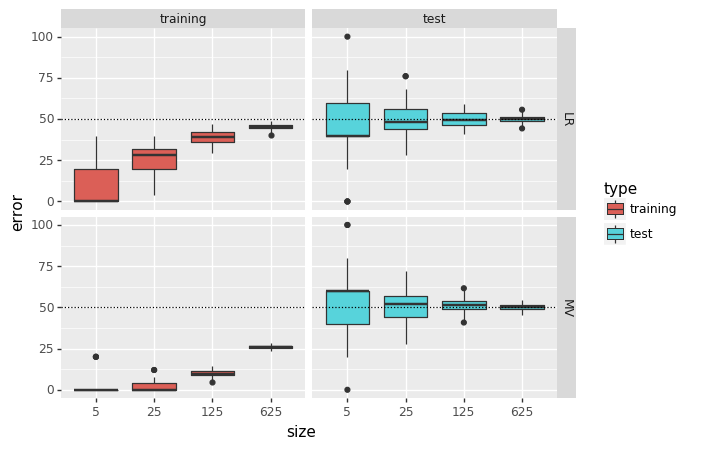

<ggplot: (7556188308)>

In [24]:
p = ggplot(data = df)
p = p + geom_boxplot(aes(x ='size', y = 'error', fill = 'type'))
p = p + geom_hline(aes(yintercept ='risk'), linetype = ':')
p = p + facet_grid(['method', 'type']) 
p.save('training_bias_1.pdf', path='results', height=6, width=12, verbose=False)
display(p)




### Visualising optimism

Lets choose experiments where test and training error is present and compute the difference between training and test errors: $$\Delta = error_{test}-error_{train}$$


In [81]:
df = (result.unstack('type').reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(optimism = lambda df: df[('error','test')] - df[('error','training')])
      .pipe(lambda df: df.loc[~df['optimism'].isna(), ['size', 'method', 'experiment','optimism']]))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_optimism = lambda df:df['optimism'].mean()))

df.columns = df.columns.droplevel(1)
head(df)

,size,method,experiment,optimism,mean_optimism
0,5,LR,0,100.0,38.297872
1,5,LR,1,40.0,38.297872
2,5,LR,2,80.0,38.297872
3,5,LR,3,20.0,38.297872
4,5,LR,4,20.0,38.297872


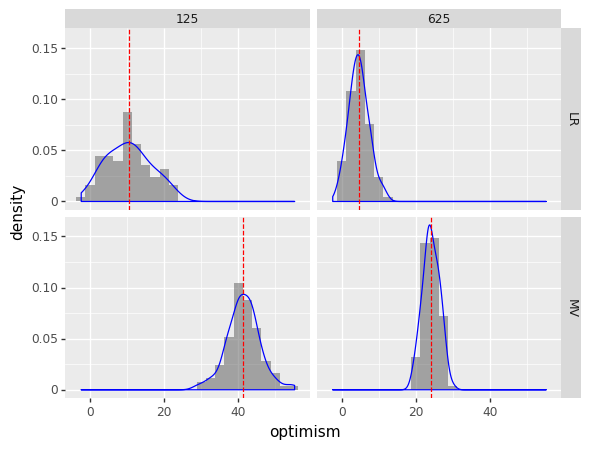

<ggplot: (7555967436)>

In [85]:
p = ggplot(df.loc[df['size'].isin([125, 625]),:])
p = p + geom_histogram(aes(x = 'optimism', y = '..density..'), binwidth=2.5, alpha=0.5)
p = p + geom_density(aes(x = 'optimism'), color="blue")
p = p + geom_vline(aes(xintercept = 'mean_optimism'), color = 'red', linetype = '--')
p = p + facet_grid(['method', 'size'])
p.save('training_bias_2.pdf', path='results', height=6, width=12, verbose=False)
display(p)

In [86]:
### Visualising correlation between training error and optimism

In [104]:
df = (result.unstack('type').reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(optimism = lambda df: df[('error','test')] - df[('error','training')])
      .assign(training = lambda df: df[('error','training')])
      .pipe(lambda df: df.loc[~df['optimism'].isna(), ['size', 'method', 'experiment', 'training', 'optimism']]))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_optimism = lambda df:df['optimism'].mean()))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_training = lambda df:df['training'].mean()))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(cor_training = lambda df:df['training'] + df['mean_optimism']))





df.columns = df.columns.droplevel(1)
head(df)

,size,method,experiment,optimism,training,mean_optimism,mean_training,cor_training
0,5,LR,0,100.0,0.0,38.297872,10.212766,38.297872
1,5,LR,1,40.0,0.0,38.297872,10.212766,38.297872
2,5,LR,2,80.0,0.0,38.297872,10.212766,38.297872
3,5,LR,3,20.0,20.0,38.297872,10.212766,58.297872
4,5,LR,4,20.0,0.0,38.297872,10.212766,38.297872


/anaconda3/envs/machine-learning/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


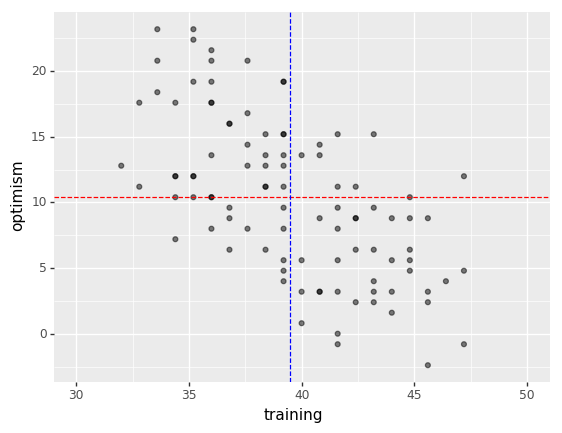

<ggplot: (7556033249)>

In [111]:
p = ggplot(df.loc[(df['size'] == 125) & (df['method'] == 'LR'),:])
p = p + geom_point(aes(x='training', y='optimism'), alpha=0.5)
p = p + geom_hline(aes(yintercept = 'mean_optimism'), color = 'red', linetype = '--')
p = p + geom_vline(aes(xintercept = 'mean_training'), color = 'blue', linetype = '--')
p = p + xlim(30,50)
p.save('training_bias_3.pdf', path='results', height=6, width=12, verbose=False)
display(p)

In [42]:
%config IPCompleter.greedy=True